##  Budget in MITgcm. Part III: Hydrostatic momentum budget
**17 Nov 2019 by MiniUFO**

---
[TOC]

---
### 1. Introduction
As Part III of a series of notebook here we will do momentum budget using the model of [MITgcm](http://mitgcm.org/), and its related [python](https://www.python.org/) analysis package like [xmitgcm](https://github.com/xgcm/xmitgcm) and [xgcm](https://github.com/xgcm/xgcm).  It will show that the budget diagnostics are very convenient under the help of these packages.  However, momentum budget is somewhat complicated than previous heat/salt (Part I and II) budget.

---

### 2. Theoretical guide
###### 2.1 General equation for the momentum
The oceanic fluid simulated by MITgcm is driven by wind stress and buoyancy forcings.  These forcings exsert their effects at the surface and their energy input is eventually dissipated by visous or radiative processes.

For the momentum budget equation, the hydrostatic zonal momentum ($u$) equation in [flux-form](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#flux-form-momentum-equations) reads:
>$$\frac{\partial u}{\partial t}=-\frac{1}{\rho_0}\frac{\partial p}{\partial x}-\mathbf u\cdot \nabla u+fv+\nabla \cdot (\mu \nabla u)+F_x \tag{1}$$

where the terms on the rhs are the pressure gradient (PGF),  advection, Coriolis force, dissipation, and the external forcing, respectively.  Note that there could be some metric terms if the coordinate is not Cartesian.  However, they are already absorbed into the advection term ([see Point 2 here](http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-December/008702.html)).

For the [vector-invariant form](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#vector-invariant-momentum-equations), the momentum equation reads:
>$$\frac{\partial \mathbf u}{\partial t}+(2\mathbf \Omega+\mathbf \zeta)\times\mathbf u-b\mathbf r+\nabla B=\nabla \cdot \mathbf \tau \tag{2}$$

In this form, the Coriolis force and metric terms will be absorbed into the advection term ([see Point 2 here](http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-December/008702.html)).


###### 2.2 Pressure gradient terms
In MITgcm, the pressure gradient term is splitted into [three parts](https://mitgcm.readthedocs.io/en/latest/overview/hydrostatic.html): the surface, hydrostatic and nonhydrostatic terms:
>$$PGF=-g\frac{\partial \eta}{\partial x}-\frac{1}{\rho_0}\frac{\partial p_{hyd}}{\partial x}-\frac{1}{\rho_0}\frac{\partial p_{nh}}{\partial x} \tag{3}$$

Notice that if your forcing includes Atmospheric pressure loading (`=atmP_load`), this contribution (`=-gradient`) needs to be added:
**`-1/rhoConst * (atmP_load(i) - atmP_load(i-1)) / dxC`**
 and the same thing applies to seaice-loading:
**`-g/rhoConst * (sIceLoad(i) - sIceLoad(i-1)) / dxC`**
The fixed density to use is `rhoConst` and not `rhoConstFresh`.

Note that the pressure gradient tendency due to surface elevation should be calculated using `PHI_SURF` rather than `ETAN`, because the implicit free surface uses `ETAN(n+1)` rather than `ETAN(n)` ([see Point c here](http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-December/008702.html) and [Point 2a here](http://mailman.mitgcm.org/pipermail/mitgcm-devel/2019-March/007065.html)).

###### 2.3 Advection and Coriolis terms
Notice that for the flux-form momentum equations, the advection and Coriolis terms are separated only if `useCDscheme=TRUE` .  In vector-invariant momentum equation, the advection and Coriolis terms are also summed up into a single (advection) term.  Note that the 3D Coriolis terms (in `u` and `w` equations) is now added to the `Um_Advec`/`Vm_Advec` and cannot be diagnosed separately ([see Point b here](http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-December/008702.html)).

###### 2.4 Viscous dissipation terms
The dissipation of momentum is splitted into lateral and vertical terms.  It also includes both explicit and implicit parts.  If `implicitVisocity=TRUE`, one has to calculate the implicit part (`VISrI_Um`/`VISrI_Vm`) oneself and add it to the total dissipation.  Therefore, the dissipation is defined as the 3D divergence of viscous stresses (or fluxes) that are explicit.  The viscous stresses includes harmonic and also biharmonic components, as well as the bottom and side drag effects near the boundaries ([see Point 3 here](http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-December/008702.html)).  Please see the [document](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#lateral-dissipation) for more details.

###### 2.6 Metric terms
Metric terms refer to the contributions arised from non-Cartesian coordinate, such as the spherical terms near the Poles.  It is already included in the `Um_Advec`/`Vm_Advec`, both [vector-invariant form](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#vector-invariant-momentum-equations) and [flux-form](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html#flux-form-momentum-equations).

###### 2.5 External forcings
External forcing includes the surface wind stress and possible body (tidal) forcing.

###### 2.6 Adams Bashforth integrator
There is a extra tendency due to the Adams-Bashforth integrator.  One need to take into account this to close the budget.

---

### 3. Practice using xgcm/xmitgcm
According to the above, the u-tendency (utdc) budget equation is:

**total_tdc = + Um_dPHdx + Um_dNHPdx - g * (PHI_SURF(i)-PHI_SURF(i-1)) / dxC**

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= + Um_Advec (+ Um_Cori only if using CD_Scheme)**

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= + Um_Diss (+ VISrI_Um, Implicit vertical viscosity tendency)**

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= + Um_Ext**

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= + AB_gU**

The MITgcm output diagnostics required for the heat budget are:

| Names in Python |  Outpus required by MITgcm  | Description |
| --------------------: | --------------------------------- | ------------- |
|  total_tdc | `TOTUTEND` | total tendency of zonal momentum |
| advct_tdc | `Um_Advec` | tendency due to advection, including Coriolis contribution if CD_Scheme is not used. Otherwise one need to add Coriolis contribution. |
| pGrdx_tdc | `Um_dPHdx`, `Um_dNPHdx`, `PHI_SURF` | tendency due to pressure gradient |
|  viscE_tdc | `Um_Diss`   | tendency due to dissipation, the 3D divergence of visous stresses as well as side and bottom drags |
|  viscI_tdc | `VISrI_Um`   | tendency due to implicit vertical viscosity |
|  exter_tdc | `Um_Ext`    | tendency due to external forcing |
| AdamB_tdc | `AB_gU`    |  tendency due to Adams-Bashforth integrator |

One can find these names in available_diagnosis.log generated in the run directory and set them in data.diagnostics for output.  Then we start the budget analysis using [python](https://www.python.org/) and related packages.

First, we define a [MomentumBudget]() class in Python code.  Using the [MomentumBudget]() class, the hydrostatic momentum budget can be easily diagnosed like:


In [3]:
import matplotlib.pyplot as plt
import xmitgcm
import xarray as xr
import sys
sys.path.append('../Python/MyPack/')
from GeoApps.Budget import MomentumBudget
from GeoApps.GridUtils import add_MITgcm_missing_metrics


indir = 'I:/channel/output_budget/'

deltaTmom = 300

dset = xmitgcm.open_mdsdataset(indir, grid_dir='I:/channel/',
                    delta_t=deltaTmom, read_grid=True,
                    prefix=['Surf2D', 'DiagU'])

dset, grid = add_MITgcm_missing_metrics(dset, periodic='X')


budget = MomentumBudget(dset, grid, var='U')

# obtains variables
TOTUTEND = dset['TOTUTEND']
Um_Advec = dset['Um_Advec']
Um_Diss  = dset['Um_Diss' ]
VISrI_Um = dset['VISrI_Um']
Um_dPHdx = dset['Um_dPHdx']
# Um_dNPHdx= dset['Um_dNPdx'] # no need for nonhydrostatic term
PHI_SURF = dset['PHI_SURF']
AB_gU    = dset['AB_gU'   ]
Um_Ext   = dset['Um_Ext'  ]

budget.cal_true_tendency(TOTUTEND)
budget.cal_advection_tendency(Um_Advec)
budget.cal_viscous_tendency(Um_Diss, VISrI_Um)
budget.cal_pressure_gradX_tendency(Um_dPHdx, None, PHI_SURF)
budget.cal_Adams_Bashforth_tendency(AB_gU)
budget.cal_external_forcing_tendency(Um_Ext)

re = budget.terms

total =  re.total_tdc
sumup = (re.advct_tdc[0]+
         re.visco_tdc[0]+ # viscous dissipation tendency = viscE_tdc + viscI_tdc
         re.pGrdx_tdc[0]+ # pressure gradient tendency = hydrx_tdc + phisx_tdc
         re.AdamB_tdc[0]+
         re.exter_tdc[0])

C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list stru

We then get a Dataset named ```re```, and it contains all the related momentum budget terms:

In [2]:
print(re)

<xarray.Dataset>
Dimensions:    (XG: 200, YC: 400, Z: 30, time: 3)
Coordinates:
    iter       (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
  * time       (time) int64 1866250800 1866261600 1866272400
  * YC         (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG         (XG) >f4 0.0 5000.0 10000.0 ... 985000.0 990000.0 995000.0
  * Z          (Z) >f4 -5.0 -15.0 -27.5 -45.0 ... -2580.0 -2830.0 -3080.0
    dyG        (YC, XG) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    dxC        (YC, XG) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    rAw        (YC, XG) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    drF        (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    PHrefC     (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    RhoRef     (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    hFacW      (Z, YC, XG) >f4 dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskW      (Z, YC, XG) bool dask

Here I only demonstrate the top APIs of [MomentumBudget]() for potential users, no specific implement details although it is not complicated.  Such API designs aim to **let the codes be the comments**: what variables are needed for each process.  Finally we get all the terms in a `xarray.Dataset`, which would be convenient to write to disk (as a [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) file).  Note that the total viscous tendency `visco_tdc` is separated into implicit (`viscI_tdc`) and explicit (`viscE_tdc`) components.  The total pressure gradient tendency `pGrdx_tdc` is separated into hydrostatic `hydrx_tdc` and surface `phisx_tdc` components.  All are stored in `re`.

As the calculation is completed, we can demonstrate the contributions from all kinds of processes and verify that the sum of all terms is exactly the total tendency for momentum.  All the terms are in unit of m s^-1 per day.

C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


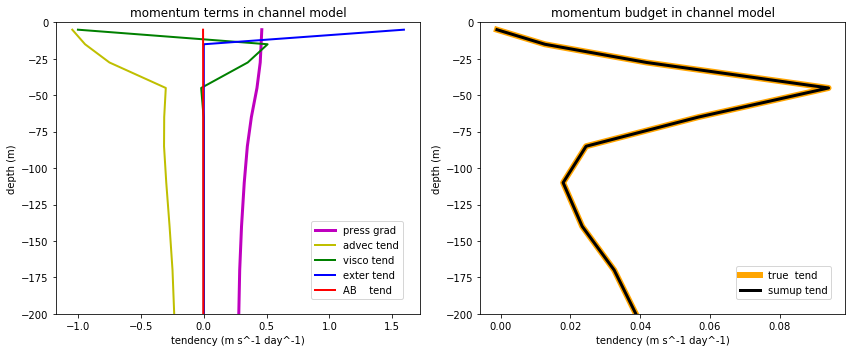

In [5]:
tidx = 0
zidx = slice(0,10)
yidx = 250 #slice(dset.YC.size)
xidx = 41# slice(dset.XC.size)

term1 = re.total_tdc[tidx,zidx,yidx,xidx]
term2 = re.advct_tdc[tidx,zidx,yidx,xidx]
term3 = re.visco_tdc[tidx,zidx,yidx,xidx]
term4 = re.pGrdx_tdc[tidx,zidx,yidx,xidx]
term5 = re.AdamB_tdc[tidx,zidx,yidx,xidx]
term6 = re.exter_tdc[tidx,zidx,yidx,xidx]
sumup = term2 + term3 + term4 + term5 + term6

# plotting the vertical profile of a single point
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

term4.plot(ax=axes[0], linewidth=3, color='m', label='press grad', y='Z')
term2.plot(ax=axes[0], linewidth=2, color='y', label='advec tend', y='Z')
term3.plot(ax=axes[0], linewidth=2, color='g', label='visco tend', y='Z')
term6.plot(ax=axes[0], linewidth=2, color='b', label='exter tend', y='Z')
term5.plot(ax=axes[0], linewidth=2, color='r', label='AB    tend', y='Z')

axes[0].set_ylim(dset.Z.values[9],0)
axes[0].set_xlabel('tendency (m s^-1 day^-1)')
axes[0].set_ylabel('depth (m)')

axes[0].set_title('momentum terms in channel model')
axes[0].legend(loc=[0.7,0.05])


term1.plot(ax=axes[1], linewidth=6,color='orange',label='true  tend',y='Z')
sumup.plot(ax=axes[1], linewidth=3,color='k'     ,label='sumup tend',y='Z')

# plt.xticks(dsr.time.values,['1','10','20','30','40','50','60','70','80'])
axes[1].set_ylim(dset.Z.values[9],0)
axes[1].set_xlabel('tendency (m s^-1 day^-1)')
axes[1].set_ylabel('depth (m)')

axes[1].set_title('momentum budget in channel model')
axes[1].legend(loc=[0.7,0.05])

plt.tight_layout()

From the above figure, we can see that momentum tendency budget is closed (exact overlap of **True tendency** and **sum-up tendency**).

#### References
1. <http://mailman.mitgcm.org/pipermail/mitgcm-devel/2019-March/007065.html>
2. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2018-September/011760.html>
3. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2018-January/011421.html>
4. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2017-December/011400.html>
5. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2017-July/011160.html>
6. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2014-February/008864.html>
7. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-December/008702.html>
8. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2011-June/007258.html>
9. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2010-December/006918.html>